<a href="https://colab.research.google.com/github/HosseinEyvazi/Density-Adjusted-MOGA-DBSCAN/blob/main/MOGA_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from scipy.stats import ttest_ind
import random
import math
from sklearn.metrics import silhouette_score, jaccard_score, recall_score, adjusted_rand_score
from scipy.spatial.distance import pdist, squareform
import pandas as pd


bounding the constraints and creating the first population (initial population)

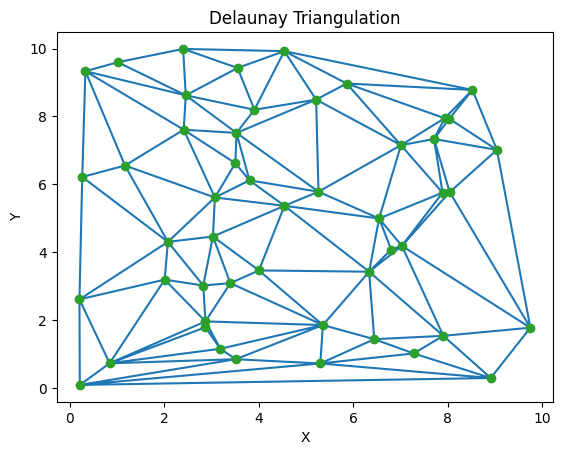

Minimum edge length: 0.09940792007425986
Maximum edge length: 8.692615774994076
Average edge length: 1.7114229806262364
Eps bounds: 0.09940792007425986, 17.385231549988152
Point [7.27766284 1.01729211] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [7.90566772 1.53569943] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [5.21458609 8.49620677] has 1 neighbors within min_length and 47 neighbors within avg_length
Point [7.88878021 5.75243287] has 1 neighbors within min_length and 49 neighbors within avg_length
Point [7.00875119 7.15346999] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [8.03969943 5.77030235] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [3.50650784 6.621811  ] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [2.82807682 3.01866479] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [3.40137328 3.08786023] has 1 

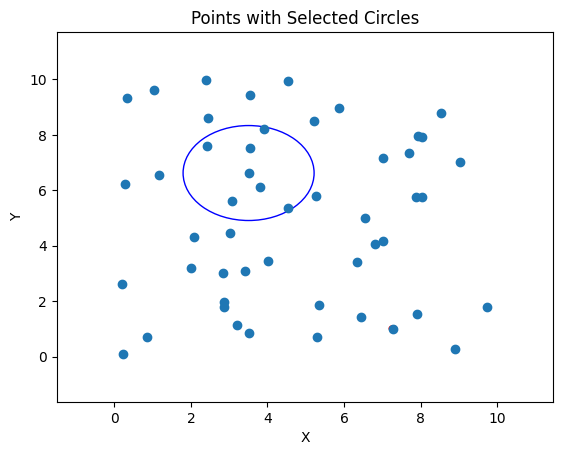

Generated dataset :
[[7.27766284 1.01729211]
 [7.90566772 1.53569943]
 [5.21458609 8.49620677]
 [7.88878021 5.75243287]
 [7.00875119 7.15346999]
 [8.03969943 5.77030235]
 [3.50650784 6.621811  ]
 [2.82807682 3.01866479]
 [3.40137328 3.08786023]
 [5.86121349 8.97068499]
 [9.74524964 1.77514327]
 [2.41470499 7.60903766]
 [9.03792905 7.01643025]
 [2.8716178  1.78727591]
 [5.26491789 5.7825012 ]
 [3.55421667 9.42876955]
 [0.3354828  9.33393787]
 [4.54541416 5.3679684 ]
 [6.54647096 4.99322749]
 [0.20981761 2.60951638]
 [7.9329415  7.94750404]
 [4.54179108 9.92428147]
 [0.26895273 6.21654293]
 [5.3029747  0.721597  ]
 [2.01167923 3.19158691]
 [3.19065647 1.15524874]
 [7.70750353 7.33430271]
 [6.80188359 4.07924179]
 [2.4582138  8.62223193]
 [6.44444529 1.43680004]
 [1.0224557  9.59776413]
 [4.00520381 3.46304585]
 [1.17230158 6.55368047]
 [0.21729603 0.08929816]
 [8.52084655 8.78115567]
 [2.40271085 9.98981889]
 [3.03249261 4.46233164]
 [3.07397595 5.61225453]
 [3.53074092 7.51528075]
 [2.8

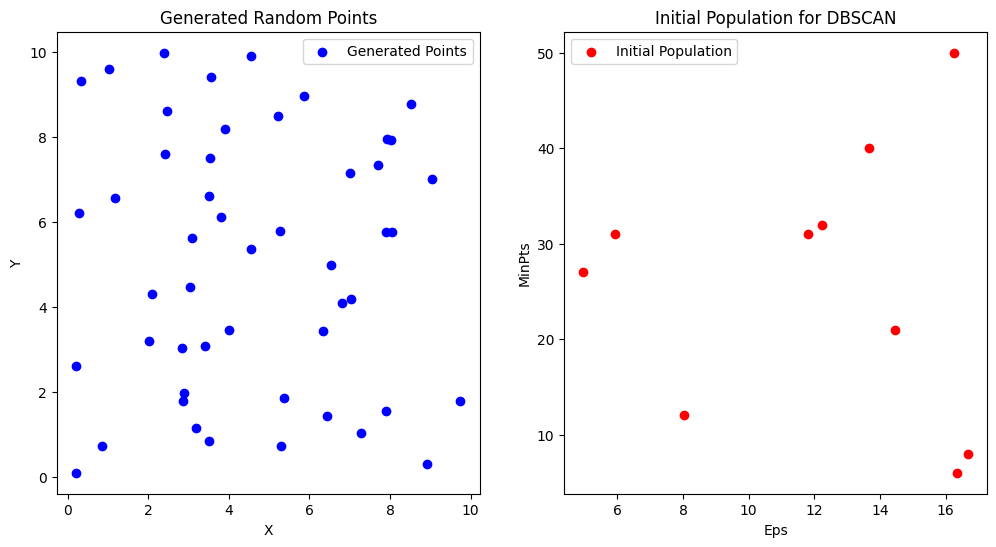

In [3]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

def generate_random_points(n, bounds): #generating dataset
    return np.random.uniform(bounds[0][0], bounds[0][1], (n, 2))

def construct_delaunay(points):
    return Delaunay(points)

def calculate_edge_lengths(triangulation):
    edges = triangulation.simplices
    lengths = []
    for edge in edges:
        for i in range(len(edge)):
            for j in range(i + 1, len(edge)):
                length = np.linalg.norm(triangulation.points[edge[i]] - triangulation.points[edge[j]])
                lengths.append(length)
    min_length = np.min(lengths)
    max_length = np.max(lengths)
    avg_length = np.mean(lengths)
    return min_length, max_length, avg_length


def plot_delaunay(points, triangulation):
    """
    Plot the Delaunay triangulation.

    Parameters:
    points (np.ndarray): Array of points.
    triangulation (scipy.spatial.Delaunay): Delaunay triangulation object.
    """
    plt.triplot(points[:, 0], points[:, 1], triangulation.simplices)
    plt.plot(points[:, 0], points[:, 1], 'o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Delaunay Triangulation')
    plt.show()

def plot_points_with_selected_circles(points, min_point, max_point, min_radius, max_radius):
    """
    Plot points with selected circles around the min and max MinPts points.

    Parameters:
    points (np.ndarray): Array of points.
    min_point (np.ndarray): Point with the minimum MinPts.
    max_point (np.ndarray): Point with the maximum MinPts.
    min_radius (float): Radius of the circle around the point with the minimum MinPts.
    max_radius (float): Radius of the circle around the point with the maximum MinPts.
    """
    fig, ax = plt.subplots()
    ax.plot(points[:, 0], points[:, 1], 'o')

    # Plot circle around min_point
    min_circle = plt.Circle(min_point, min_radius, color='r', fill=False)
    ax.add_artist(min_circle)

    # Plot circle around max_point
    max_circle = plt.Circle(max_point, max_radius, color='b', fill=False)
    ax.add_artist(max_circle)

    ax.set_xlim(min(points[:, 0]) - max_radius, max(points[:, 0]) + max_radius)
    ax.set_ylim(min(points[:, 1]) - max_radius, max(points[:, 1]) + max_radius)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Points with Selected Circles')
    plt.show()

#bounding the constraints
def initialize_dbscan_parameters(points):
    """
    Initialize DBSCAN parameters (Eps and MinPts) using Delaunay triangulation.

    Parameters:
    num_points (int): Number of points to generate.
    bounds (tuple): ((x_min, x_max), (y_min, y_max)) bounds for the points.

    Returns:
    tuple: (eps_min, eps_max, min_pts_min, min_pts_max)
    """
    # Generate random points

    # Construct Delaunay triangulation
    triangulation = construct_delaunay(points)

    # Plot Delaunay triangulation
    plot_delaunay(points, triangulation)

    # Calculate edge lengths
    min_length, max_length, avg_length = calculate_edge_lengths(triangulation)
    print(f"Minimum edge length: {min_length}")
    print(f"Maximum edge length: {max_length}")
    print(f"Average edge length: {avg_length}")

    # Set the bounds for Eps parameter
    eps_min = min_length
    eps_max = max_length*2     ##IMPORTANT NOTE
    print(f"Eps bounds: {eps_min}, {eps_max}")

    # Determine MinPts bounds
    neighbor_counts_min = []
    neighbor_counts_max = []

    for point in points:
        neighbors_min = np.sum(np.linalg.norm(points - point, axis=1) <= min_length)
        neighbors_max = np.sum(np.linalg.norm(points - point, axis=1) <= max_length) ##IMPORTANT NOTE
        neighbor_counts_min.append(neighbors_min)
        neighbor_counts_max.append(neighbors_max)
        print(f"Point {point} has {neighbors_min} neighbors within min_length and {neighbors_max} neighbors within avg_length")

    min_pts_min = min(neighbor_counts_min)
    min_pts_max = max(neighbor_counts_max)
    min_point = points[np.argmin(neighbor_counts_min)]
    max_point = points[np.argmax(neighbor_counts_max)]

    print(f"MinPts bounds   +1(min): {min_pts_min+1}, {min_pts_max+1}")

    # Plot points with selected circles to visualize min and max MinPts
    plot_points_with_selected_circles(points, min_point, max_point, min_length, avg_length)

    return eps_min+1, eps_max, min_pts_min, min_pts_max


def generate_initial_population_from_points(points, population_size):
    eps_min, eps_max, min_pts_min, min_pts_max = initialize_dbscan_parameters(points)

    population = np.zeros((population_size, 2))
    population[:, 0] = np.random.uniform(eps_min, eps_max, population_size)
    population[:, 1] = np.random.randint(min_pts_min + 1, min_pts_max +1, population_size)

    return population

# Test the provided code
n_points = 50
bounds = [[0, 10], [0, 10]]
points = generate_random_points(n_points, bounds)

population_size = 10
initial_population = generate_initial_population_from_points(points, population_size)

print("Generated dataset :")
print(points)

print("\nInitial Population (eps, minPts):")
print(initial_population)

# Plot the generated points and initial population
plt.figure(figsize=(12, 6))

# Plot generated points
plt.subplot(1, 2, 1)
plt.scatter(points[:, 0], points[:, 1], c='blue', label='Generated Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Generated Random Points')

# Plot initial population
plt.subplot(1, 2, 2)
plt.scatter(initial_population[:, 0], initial_population[:, 1], c='red', label='Initial Population')
plt.xlabel('Eps')
plt.ylabel('MinPts')
plt.legend()
plt.title('Initial Population for DBSCAN')

plt.show()


crossover and mutation and applying them on a population

Offspring: [2. 4.]


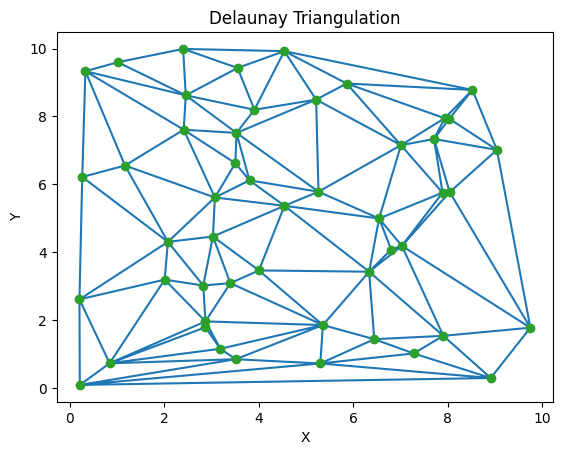

Minimum edge length: 0.09940792007425986
Maximum edge length: 8.692615774994076
Average edge length: 1.7114229806262364
Eps bounds: 0.09940792007425986, 17.385231549988152
Point [7.27766284 1.01729211] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [7.90566772 1.53569943] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [5.21458609 8.49620677] has 1 neighbors within min_length and 47 neighbors within avg_length
Point [7.88878021 5.75243287] has 1 neighbors within min_length and 49 neighbors within avg_length
Point [7.00875119 7.15346999] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [8.03969943 5.77030235] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [3.50650784 6.621811  ] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [2.82807682 3.01866479] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [3.40137328 3.08786023] has 1 

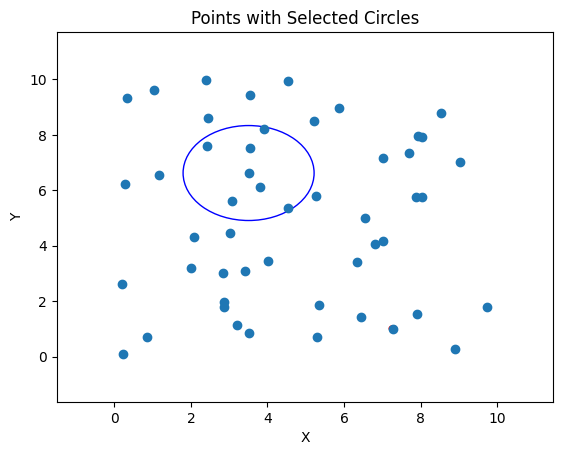

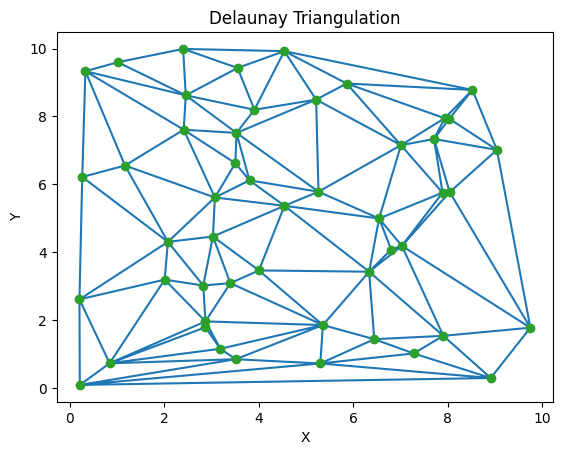

Minimum edge length: 0.09940792007425986
Maximum edge length: 8.692615774994076
Average edge length: 1.7114229806262364
Eps bounds: 0.09940792007425986, 17.385231549988152
Point [7.27766284 1.01729211] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [7.90566772 1.53569943] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [5.21458609 8.49620677] has 1 neighbors within min_length and 47 neighbors within avg_length
Point [7.88878021 5.75243287] has 1 neighbors within min_length and 49 neighbors within avg_length
Point [7.00875119 7.15346999] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [8.03969943 5.77030235] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [3.50650784 6.621811  ] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [2.82807682 3.01866479] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [3.40137328 3.08786023] has 1 

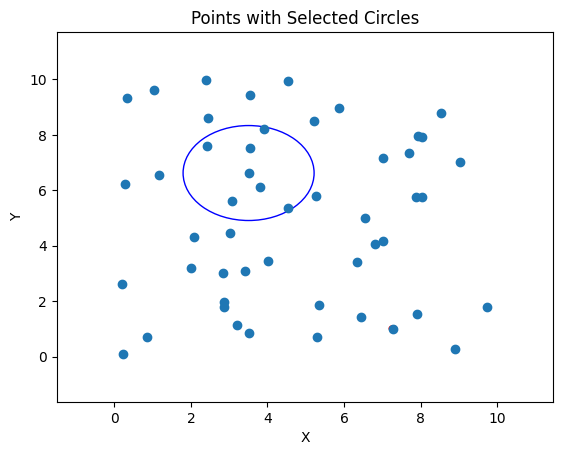

Initial Population:
[[ 2.25012866 20.        ]
 [12.42215366 10.        ]
 [ 2.88811357 17.        ]
 [ 2.96847787  3.        ]
 [ 4.61547417 30.        ]]

New Population after Crossover and Mutation:
[[12.42215366 20.        ]
 [ 2.25012866 10.        ]
 [ 2.88811357 17.        ]
 [ 2.25012866 20.        ]
 [ 4.61547417 30.        ]
 [ 2.96847787  3.        ]
 [ 4.61547417 29.        ]
 [12.42215366 10.        ]
 [ 2.88811357 10.        ]
 [12.42215366 17.        ]]


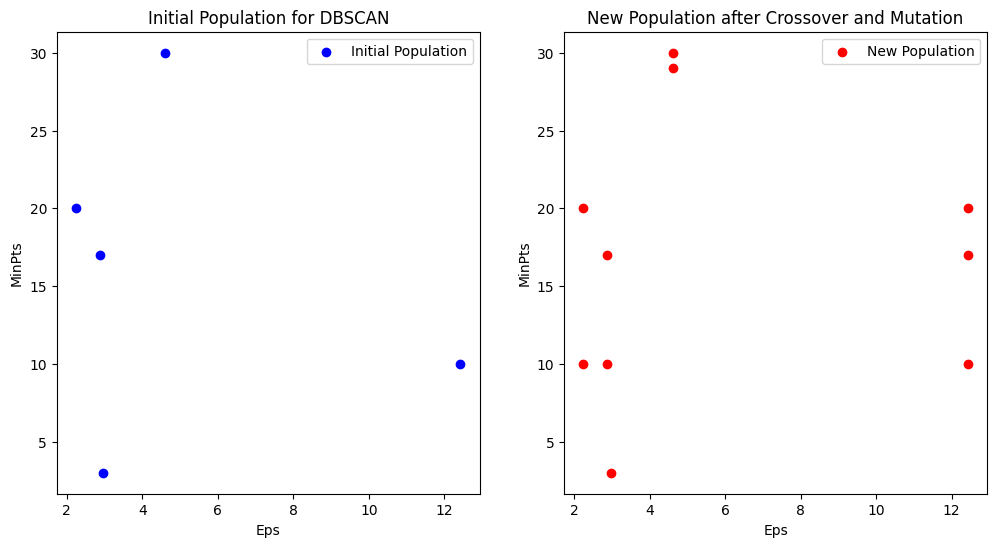

In [4]:
def crossover(parent1, parent2, crossover_rate=1):
    """
    Perform single-point crossover on two parents to produce one offspring based on the condition.

    Parameters:
    parent1 (np.ndarray): First parent individual.
    parent2 (np.ndarray): Second parent individual.
    crossover_rate (float): Probability of performing crossover.

    Returns:
    np.ndarray: One offspring individual.
    """
    if random.random() < crossover_rate:
        choice = random.choice([1, 2, 3])
        if choice == 1:
            # Use the minPts of one of the parents and avg of them for eps
            offspring = np.array([(parent1[0] + parent2[0]) / 2, parent1[1]])
        elif choice == 2:
            # Use the avg of eps for one of the parents and minPts for the other
            offspring = np.array([(parent1[0] + parent2[0]) / 2, parent2[1]])
        elif choice == 3:
            # Use the minPts of one of the parents and eps of the other
            offspring = np.array([parent1[0], parent2[1]])
    else:
        offspring = parent1.copy() if random.random() < 0.5 else parent2.copy()

    return offspring



# Example usage
parent1 = np.array([1, 2])
parent2 = np.array([3, 4])
offspring = crossover(parent1, parent2)
print(f"Offspring: {offspring}")

def mutation(individual, eps_bounds, min_pts_bounds, mutation_rate=0.1):
    """
    Perform mutation on an individual by slightly altering its eps and min_samples values.

    Parameters:
    individual (np.ndarray): Individual to mutate.
    eps_bounds (tuple): (eps_min, eps_max) bounds for the eps parameter.
    min_pts_bounds (tuple): (min_pts_min, min_pts_max) bounds for the min_samples parameter.
    mutation_rate (float): Probability of performing mutation.

    Returns:
    np.ndarray: Mutated individual.
    """
    eps_min, eps_max = eps_bounds
    min_pts_min, min_pts_max = min_pts_bounds

    if random.random() < mutation_rate:
        individual[0] = np.clip(individual[0] + np.random.uniform(-0.1, 0.1), eps_min, eps_max)

    if random.random() < mutation_rate:
        individual[1] = np.clip(individual[1] + random.randint(-1, 1), min_pts_min, min_pts_max) #min_pts_max: This is the maximum bound for minPts, ensuring that the adjusted value does not exceed this maximum.

    return individual


def apply_crossover_and_mutation(population, eps_bounds, min_pts_bounds, new_population_size, crossover_rate=1, mutation_rate=0.1):
    """
    Apply crossover and mutation on the population to generate a new population.

    Parameters:
    population (np.ndarray): Current population of individuals.
    eps_bounds (tuple): (eps_min, eps_max) bounds for the eps parameter.
    min_pts_bounds (tuple): (min_pts_min, min_pts_max) bounds for the min_samples parameter.
    new_population_size (int): Desired size of the new population.
    crossover_rate (float): Probability of performing crossover.
    mutation_rate (float): Probability of performing mutation.

    Returns:
    np.ndarray: New population after crossover and mutation.
    """
    new_population = []

    # Ensure new population size is even for pairing
    if new_population_size % 2 != 0:
        new_population_size += 1

    while len(new_population) < new_population_size:
        parent1, parent2 = random.sample(list(population), 2)
        if random.random() < crossover_rate:
            crossover_point = random.randint(1, len(parent1) - 1)
            offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
            offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        else:
            offspring1, offspring2 = parent1.copy(), parent2.copy()

        # Apply mutation
        offspring1 = mutation(offspring1, eps_bounds, min_pts_bounds, mutation_rate)
        offspring2 = mutation(offspring2, eps_bounds, min_pts_bounds, mutation_rate)

        new_population.extend([offspring1, offspring2])

    return np.array(new_population[:new_population_size])

# Define bounds for eps and minPts
eps_min, eps_max, min_pts_min, min_pts_max = initialize_dbscan_parameters(points)
eps_bounds = (eps_min, eps_max)
min_pts_bounds = (min_pts_min, min_pts_max)

# Global variable
population_size = math.floor(n_points * 10 / 100)

# Generate initial population
initial_population = generate_initial_population_from_points(points, population_size)

# Define the size of the new population
new_population_size = 10

# Apply crossover and mutation on the initial population
new_population = apply_crossover_and_mutation(
    initial_population, eps_bounds, min_pts_bounds, new_population_size, crossover_rate=0.3, mutation_rate=0.1
)

print("Initial Population:")
print(initial_population)

print("\nNew Population after Crossover and Mutation:")
print(new_population)

# Plot the initial and new population for comparison
plt.figure(figsize=(12, 6))

# Plot initial population
plt.subplot(1, 2, 1)
plt.scatter(initial_population[:, 0], initial_population[:, 1], c='blue', label='Initial Population')
plt.xlabel('Eps')
plt.ylabel('MinPts')
plt.legend()
plt.title('Initial Population for DBSCAN')

# Plot new population
plt.subplot(1, 2, 2)
plt.scatter(new_population[:, 0], new_population[:, 1], c='red', label='New Population')
plt.xlabel('Eps')
plt.ylabel('MinPts')
plt.legend()
plt.title('New Population after Crossover and Mutation')

plt.show()

union of 'applying mutation and crossover' funcrion and our population

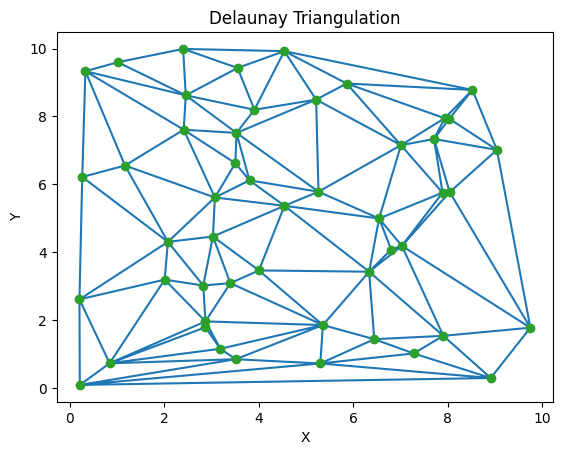

Minimum edge length: 0.09940792007425986
Maximum edge length: 8.692615774994076
Average edge length: 1.7114229806262364
Eps bounds: 0.09940792007425986, 17.385231549988152
Point [7.27766284 1.01729211] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [7.90566772 1.53569943] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [5.21458609 8.49620677] has 1 neighbors within min_length and 47 neighbors within avg_length
Point [7.88878021 5.75243287] has 1 neighbors within min_length and 49 neighbors within avg_length
Point [7.00875119 7.15346999] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [8.03969943 5.77030235] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [3.50650784 6.621811  ] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [2.82807682 3.01866479] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [3.40137328 3.08786023] has 1 

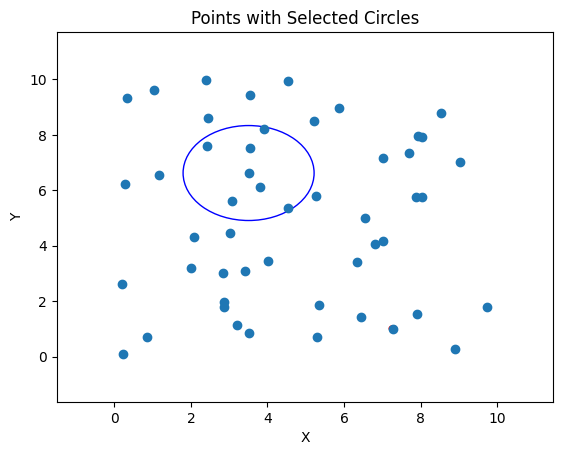

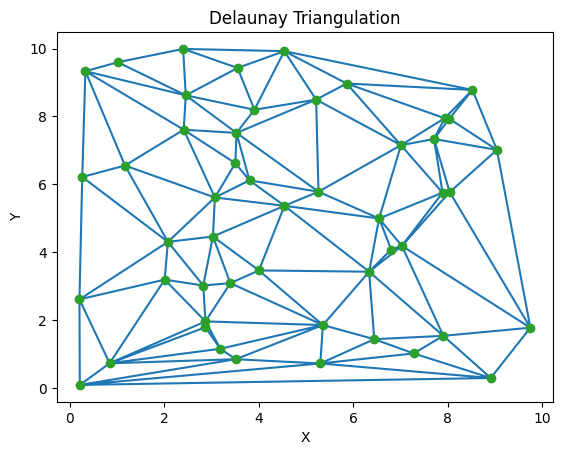

Minimum edge length: 0.09940792007425986
Maximum edge length: 8.692615774994076
Average edge length: 1.7114229806262364
Eps bounds: 0.09940792007425986, 17.385231549988152
Point [7.27766284 1.01729211] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [7.90566772 1.53569943] has 1 neighbors within min_length and 43 neighbors within avg_length
Point [5.21458609 8.49620677] has 1 neighbors within min_length and 47 neighbors within avg_length
Point [7.88878021 5.75243287] has 1 neighbors within min_length and 49 neighbors within avg_length
Point [7.00875119 7.15346999] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [8.03969943 5.77030235] has 1 neighbors within min_length and 48 neighbors within avg_length
Point [3.50650784 6.621811  ] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [2.82807682 3.01866479] has 1 neighbors within min_length and 50 neighbors within avg_length
Point [3.40137328 3.08786023] has 1 

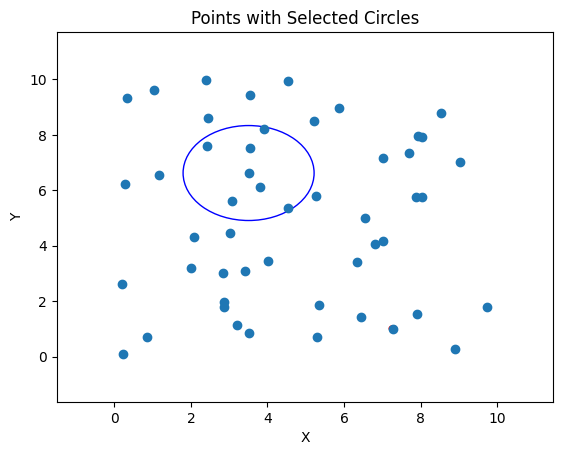

Population 1:
[[ 7.98993973  2.        ]
 [15.16068501 24.        ]
 [ 7.51306458 19.        ]
 [ 5.03746479 25.        ]
 [11.38682401 41.        ]]

Population 2:
[[14.2001316   5.        ]
 [ 2.17503474 41.        ]
 [15.72877499  3.        ]
 [ 5.83919351 36.        ]
 [12.27572519 26.        ]]

Union of Populations:
[[ 7.98993973  2.        ]
 [15.16068501 24.        ]
 [ 7.51306458 19.        ]
 [ 5.03746479 25.        ]
 [11.38682401 41.        ]
 [14.2001316   5.        ]
 [ 2.17503474 41.        ]
 [15.72877499  3.        ]
 [ 5.83919351 36.        ]
 [12.27572519 26.        ]]


In [5]:
def union_of_populations(population1, population2):
    """
    Create the union of two populations.

    Parameters:
    population1 (np.ndarray): The first population array.
    population2 (np.ndarray): The second population array.

    Returns:
    np.ndarray: The union of the two populations.
    """
    return np.vstack((population1, population2))

# Example usage
population1 = generate_initial_population_from_points(points, population_size)
population2 = generate_initial_population_from_points(points, population_size)

union_population = union_of_populations(population1, population2)

print("Population 1:")
print(population1)
print("\nPopulation 2:")
print(population2)
print("\nUnion of Populations:")
print(union_population)




we should select the good individulas of the unioned population

indices and getting the indices of a population and  evaluating (getting the indices) of a population


In [6]:

def dunn_index(points, labels):
    unique_labels = np.unique(labels)
    unique_labels = unique_labels[unique_labels != -1]
    num_clusters = len(unique_labels)
    if num_clusters < 2:
        return 0

    distances = pairwise_distances(points)

    delta = np.inf
    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = points[labels == unique_labels[i]]
            cluster_j = points[labels == unique_labels[j]]
            intercluster_distances = distances[np.ix_(labels == unique_labels[i], labels == unique_labels[j])]
            delta = min(delta, intercluster_distances.min())

    intra_cluster_distances = []
    for label in unique_labels:
        cluster = points[labels == label]
        if len(cluster) > 1:
            intra_cluster_distances.append(distances[np.ix_(labels == label, labels == label)].max())

    max_intra_cluster_distance = max(intra_cluster_distances) if intra_cluster_distances else 0

    if max_intra_cluster_distance == 0:
        return 0

    dunn_idx = delta / max_intra_cluster_distance
    return dunn_idx


#testing dunn index
# Sample data points
points = np.array([
    [1, 2], [2, 2], [3, 2],  # Cluster 1
    [8, 8], [8, 9], [7, 8],  # Cluster 2
    [5, 5], [6, 5], [5, 6]   # Cluster 3
])

# Corresponding labels for the clusters
labels = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

# Evaluate the clustering
dunn_idx = dunn_index(points, labels)
print(f"Dunn Index: {dunn_idx}")

def outlier_index(points, labels):
    outliers = points[labels == -1]
    clusters = [points[labels == i] for i in np.unique(labels) if i != -1]

    if len(outliers) == 0:
        return 0

    if len(clusters) == 0:
        # All points are outliers
        return float('inf')  # or a large number like 1e6

    min_distances = []
    for outlier in outliers:
        min_dist = np.min([np.min(cdist([outlier], cluster)) for cluster in clusters])
        min_distances.append(min_dist)

    outlier_idx = np.mean(min_distances)

    #print(f"Outlier Min Distances: {min_distances}")

    return outlier_idx


def evaluate_population(population, points):
    """
    Evaluate the population by running DBSCAN on each individual and computing the outlier index and Dunn index.
    Also, plot the DBSCAN results for each individual.

    Parameters:
    population (np.ndarray): Array of individuals, where each individual has two genes [eps, minPts].
    points (np.ndarray): Array of points to be clustered.

    Returns:
    np.ndarray: Array of shape (population_size, 2) where each row represents [outlier_index, dunn_index] for an individual.
    """
    indices = np.zeros((len(population), 2))

    for i, individual in enumerate(population):
        eps, min_pts = individual
        dbscan = DBSCAN(eps=eps, min_samples=int(min_pts))
        labels = dbscan.fit_predict(points)
        indices[i, 0] = outlier_index(points, labels)
        indices[i, 1] = dunn_index(points, labels)

        # Plotting the DBSCAN results
        #plt.figure()
        unique_labels = np.unique(labels)
        #colors = plt.cm.get_cmap("tab10", len(unique_labels))
        #for label in unique_labels:
            #if label == -1:
                # Black color for noise.
            #    color = [0, 0, 0, 1]
            #    label_name = "Outliers"
            #else:
            #    color = colors(label)
            #    label_name = f"Cluster {label}"
            #plt.scatter(points[labels == label][:, 0], points[labels == label][:, 1], s=50, c=[color], label=label_name)

        #plt.title(f'DBSCAN (Eps={eps}, MinPts={min_pts})')
        #plt.xlabel('Feature 1')
        #plt.ylabel('Feature 2')
        #plt.legend()
        #plt.show()  #IMPORTANT NOTE

    return indices




Dunn Index: 1.4142135623730951


selection of a unioned(union of result of the mutation and crossover and current population) population

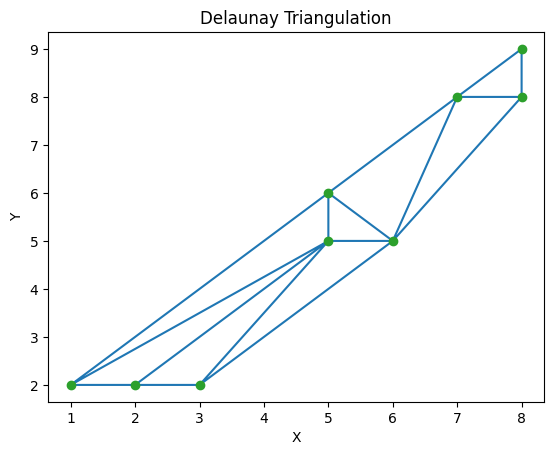

Minimum edge length: 1.0
Maximum edge length: 5.656854249492381
Average edge length: 2.5665438862268513
Eps bounds: 1.0, 11.313708498984761
Point [1 2] has 2 neighbors within min_length and 5 neighbors within avg_length
Point [2 2] has 3 neighbors within min_length and 6 neighbors within avg_length
Point [3 2] has 2 neighbors within min_length and 6 neighbors within avg_length
Point [8 8] has 3 neighbors within min_length and 6 neighbors within avg_length
Point [8 9] has 2 neighbors within min_length and 6 neighbors within avg_length
Point [7 8] has 2 neighbors within min_length and 6 neighbors within avg_length
Point [5 5] has 3 neighbors within min_length and 9 neighbors within avg_length
Point [6 5] has 2 neighbors within min_length and 8 neighbors within avg_length
Point [5 6] has 2 neighbors within min_length and 9 neighbors within avg_length
MinPts bounds   +1(min): 3, 10


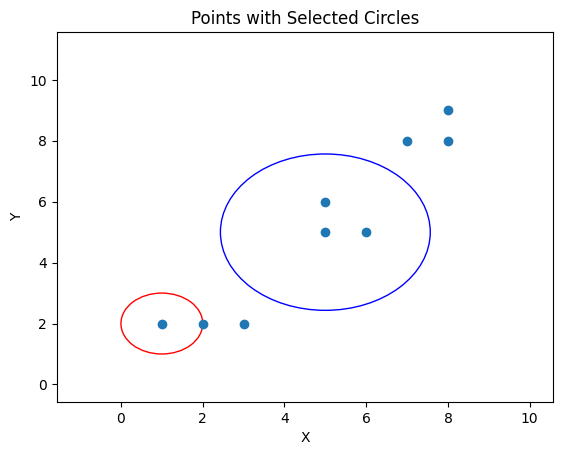

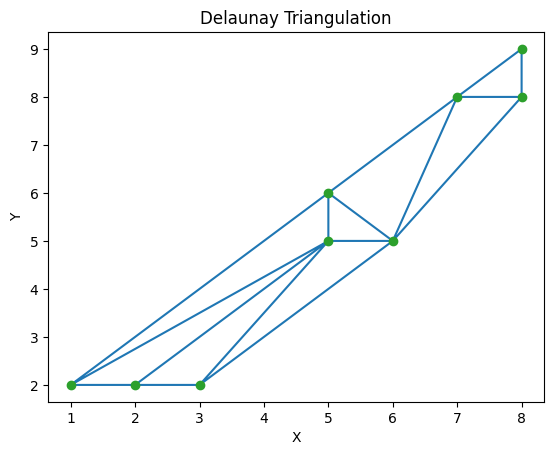

Minimum edge length: 1.0
Maximum edge length: 5.656854249492381
Average edge length: 2.5665438862268513
Eps bounds: 1.0, 11.313708498984761
Point [1 2] has 2 neighbors within min_length and 5 neighbors within avg_length
Point [2 2] has 3 neighbors within min_length and 6 neighbors within avg_length
Point [3 2] has 2 neighbors within min_length and 6 neighbors within avg_length
Point [8 8] has 3 neighbors within min_length and 6 neighbors within avg_length
Point [8 9] has 2 neighbors within min_length and 6 neighbors within avg_length
Point [7 8] has 2 neighbors within min_length and 6 neighbors within avg_length
Point [5 5] has 3 neighbors within min_length and 9 neighbors within avg_length
Point [6 5] has 2 neighbors within min_length and 8 neighbors within avg_length
Point [5 6] has 2 neighbors within min_length and 9 neighbors within avg_length
MinPts bounds   +1(min): 3, 10


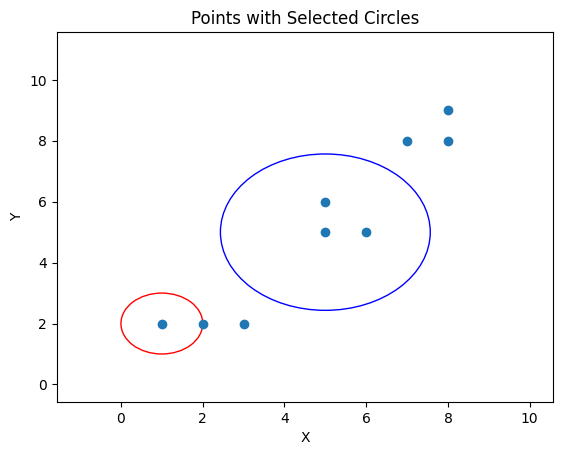

Combined Population:
[[11.20093572  3.        ]
 [ 9.22084984  3.        ]
 [10.50515756  3.        ]
 [ 6.28704822  8.        ]
 [ 2.2756292   5.        ]
 [ 8.98657249  4.        ]
 [ 3.5253134   3.        ]
 [ 8.85079366  3.        ]
 [ 6.78405386  4.        ]
 [ 9.37728633  6.        ]
 [ 3.25922822  3.        ]
 [ 5.23113147  7.        ]
 [ 9.43357888  5.        ]
 [ 7.62099848  9.        ]
 [ 6.43062118  5.        ]
 [ 8.90400686  3.        ]
 [ 3.99590105  9.        ]
 [ 5.03678176  3.        ]
 [ 2.58818816  5.        ]
 [ 9.29399112  8.        ]]

Non-dominated Fronts:
Front 1: [4, 16]
Front 2: [18, 3, 11, 13]
Front 3: [10, 14, 19]
Front 4: [6, 8, 9]
Front 5: [17, 5, 12]
Front 6: [7]
Front 7: [15]
Front 8: [1]
Front 9: [2]
Front 10: [0]
Population:
[[ 0.44133634  9.        ]
 [ 0.42616409 10.        ]
 [ 0.27514378  7.        ]
 [ 0.45019541  2.        ]
 [ 0.9301822   3.        ]
 [ 1.04717269 10.        ]
 [ 0.36717148  7.        ]
 [ 0.5414328   2.        ]
 [ 1.38277005 10

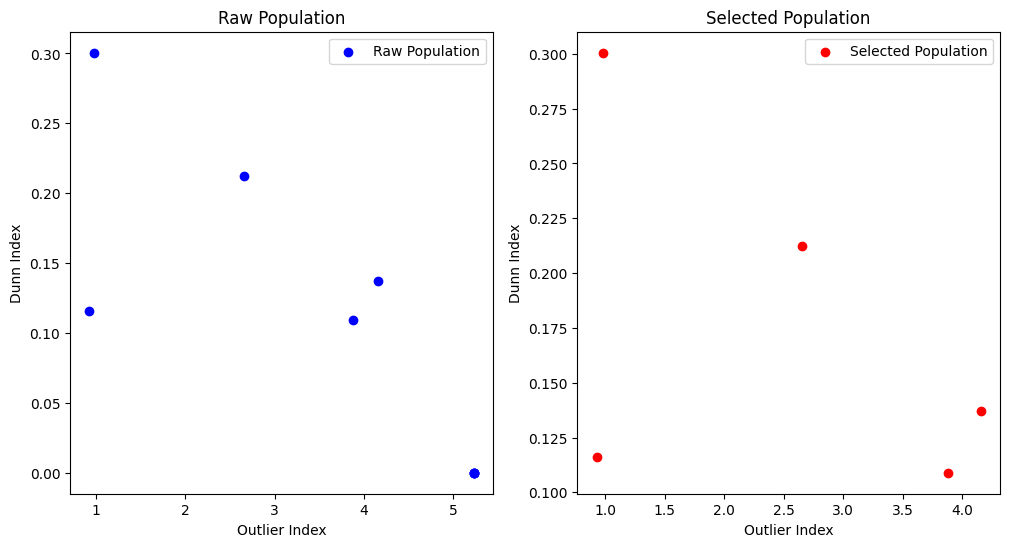

In [7]:


def crowding_distance(front, points):
    """
    Calculate the crowding distance for each point in a front.

    Parameters:
    front (list): List of indices representing the front.
    points (np.ndarray): Array of points where each point has two values: [outlier_index, dunn_index]

    Returns:
    list: List of tuples (index, crowding_distance)
    """
    if len(front) == 0:
        return []

    distances = np.zeros(len(front))
    sorted_indices = np.argsort(points[front], axis=0)

    for m in range(points.shape[1]):
        distances[sorted_indices[0, m]] = np.inf
        distances[sorted_indices[-1, m]] = np.inf
        for i in range(1, len(front) - 1):
            if points[sorted_indices[-1, m], m] == points[sorted_indices[0, m], m]:
                norm_diff = 0
            else:
                norm_diff = (points[sorted_indices[i + 1, m], m] - points[sorted_indices[i - 1, m], m]) / (points[sorted_indices[-1, m], m] - points[sorted_indices[0, m], m])
            distances[sorted_indices[i, m]] += norm_diff

    return list(zip(front, distances))

def non_dominated_sorting(points_combined):
    """
    Perform non-dominated sorting on the given points.

    Parameters:
    points_combined (np.ndarray): Array of points where each point has two values: [outlier_index, dunn_index]

    Returns:
    list: List of fronts, each containing indices of points in that front.
    """
    fronts = []
    S = [[] for _ in range(len(points_combined))]
    n = [0 for _ in range(len(points_combined))]
    rank = [0 for _ in range(len(points_combined))]

    for p in range(len(points_combined)):
        for q in range(len(points_combined)):
            # Minimize outlier_index (points_combined[p][0]) and maximize dunn_index (points_combined[p][1])
            if (points_combined[p][0] <= points_combined[q][0] and points_combined[p][1] >= points_combined[q][1]) and (points_combined[p][0] < points_combined[q][0] or points_combined[p][1] > points_combined[q][1]):
                S[p].append(q)
            elif (points_combined[q][0] <= points_combined[p][0] and points_combined[q][1] >= points_combined[p][1]) and (points_combined[q][0] < points_combined[p][0] or points_combined[q][1] > points_combined[p][1]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if len(fronts) == 0:
                fronts.append([])
            fronts[0].append(p)

    i = 0
    while len(fronts[i]) > 0:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)

    return fronts[:-1]

def plot_fronts(points_combined, fronts):
    #plt.figure(figsize=(10, 7))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i, front in enumerate(fronts):
        front_points = points_combined[front]
    #    plt.scatter(front_points[:, 0], front_points[:, 1], color=colors[i % len(colors)], label=f'Front {i+1}')
    #plt.xlabel('Outlier Index (Minimize)')
    #plt.ylabel('Dunn Index (Maximize)')
    #plt.legend()
    #plt.title('Non-dominated Sorting')
    #plt.show()   #NOTE IMPORTANT

# Example usage
points = np.array([
    [1, 2], [2, 2], [3, 2],
    [8, 8], [8, 9], [7, 8],
    [5, 5], [6, 5], [5, 6]
])
population_size = 10
population1 = generate_initial_population_from_points(points, population_size)
population2 = generate_initial_population_from_points(points, population_size)

combined_population = union_of_populations(population1, population2)
fronts = non_dominated_sorting(combined_population)



print("Combined Population:")
print(combined_population)
print("\nNon-dominated Fronts:")
for i, front in enumerate(fronts):
    print(f"Front {i+1}: {front}")

plot_fronts(combined_population, fronts)








# Example usage
# Create a dataset with 3 clusters and some outliers
points, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
outliers = np.random.uniform(low=-10, high=10, size=(20, 2))
points = np.vstack([points, outliers])

# Example usage
population_size = 10

# Assuming you already have this function in your code
# population = generate_initial_population_from_points(points, population_size)

# For testing, let's generate a population with appropriate ranges directly here:
eps_min, eps_max = 0.1, 1.5
min_pts_min, min_pts_max = 2, 10
population = np.zeros((population_size, 2))
population[:, 0] = np.random.uniform(eps_min, eps_max, population_size)  # Eps values
population[:, 1] = np.random.randint(min_pts_min, min_pts_max + 1, population_size)  # MinPts values

indices = evaluate_population(population, points)

print("Population:")
print(population)
print("\nOutlier Index and Dunn Index for each individual:")
print(indices)




def next_population_selection(population, points_combined, new_population_size):
    fronts = non_dominated_sorting(points_combined)
    new_population = []

    for front in fronts:
        if len(new_population) + len(front) > new_population_size:
            distances = crowding_distance(front, points_combined)
            distances.sort(key=lambda x: x[1], reverse=True)
            new_population.extend([population[i] for i, _ in distances[:new_population_size - len(new_population)]])
            break
        else:
            new_population.extend(population[front])

    return np.array(new_population)

# Create a dataset with 3 clusters and some outliers
points, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)
outliers = np.random.uniform(low=-10, high=10, size=(20, 2))
points = np.vstack([points, outliers])
# Generate a population with appropriate ranges directly here:
population_size = 10
eps_min, eps_max = 0.1, 1.5
min_pts_min, min_pts_max = 2, 10
population = np.zeros((population_size, 2))
population[:, 0] = np.random.uniform(eps_min, eps_max, population_size)  # Random Eps values
population[:, 1] = np.random.randint(min_pts_min, min_pts_max + 1, population_size)  # Random MinPts values

# Evaluate population
indices = evaluate_population(population, points)
print("old indices:")
print(indices)

# Next population selection
new_population_size = 5
new_population = next_population_selection(population, indices, new_population_size)

# Plot raw population and selected population
plt.figure(figsize=(12, 6))

# Plot raw population
plt.subplot(1, 2, 1)
plt.scatter(indices[:, 0], indices[:, 1], c='blue', label='Raw Population')
plt.xlabel('Outlier Index')
plt.ylabel('Dunn Index')
plt.legend()
plt.title('Raw Population')

# Plot selected population
new_indices = np.array([indices[np.where((population == ind).all(axis=1))[0][0]] for ind in new_population])
print("new population indices:")
print(new_indices)
plt.subplot(1, 2, 2)
plt.scatter(new_indices[:, 0], new_indices[:, 1], c='red', label='Selected Population')
plt.xlabel('Outlier Index')
plt.ylabel('Dunn Index')
plt.legend()
plt.title('Selected Population')

plt.show()


plotting the latest DBSCAN result and showing their indices

<ipython-input-24-e563a96b3ac5>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


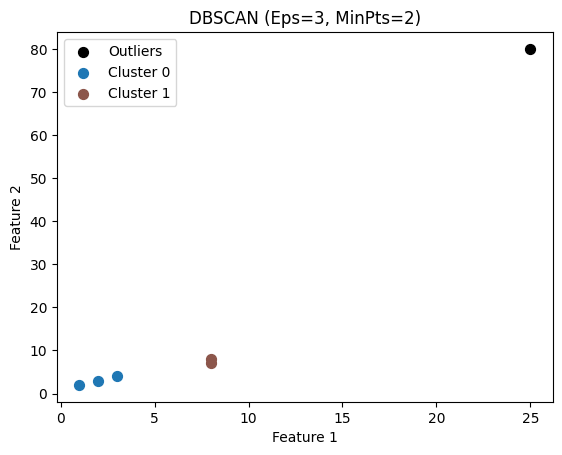

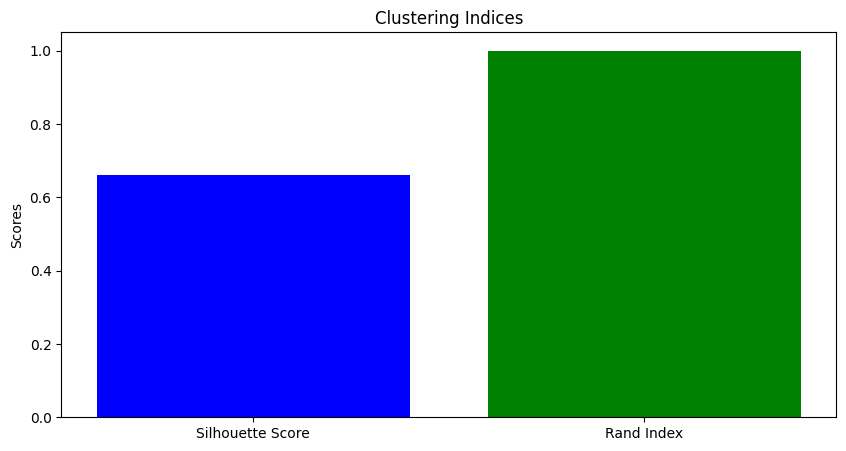

{'Silhouette Score': 0.6600383608117983, 'Rand Index': 1.0}


In [24]:

def plot_clusters(points, labels, eps, min_samples):
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap("tab10", len(unique_labels))
    for label in unique_labels:
        if label == -1:
            # Black color for noise.
            color = [0, 0, 0, 1]
            label_name = "Outliers"
        else:
            color = colors(label)
            label_name = f"Cluster {label}"
        plt.scatter(points[labels == label][:, 0], points[labels == label][:, 1], s=50, c=[color], label=label_name)

    plt.title(f'DBSCAN (Eps={eps}, MinPts={min_samples})')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

def plot_indices(indices):
    names = list(indices.keys())
    values = list(indices.values())

    plt.figure(figsize=(10, 5))

    plt.bar(names, values, color=['blue', 'green', 'red', 'purple'])
    plt.ylabel('Scores')
    plt.title('Clustering Indices')
    plt.show()

def evaluate_dbscan(points, eps, min_samples, true_labels=None):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(points)

    # Compute indices
    dunn_idx = dunn_index(points, labels)
    silhouette_avg = silhouette_score(points, labels) if len(set(labels)) > 1 else -1
    jaccard = jaccard_score(true_labels, labels, average='weighted') if true_labels is not None else None
    rand_idx = adjusted_rand_score(true_labels, labels) if true_labels is not None else None

    # Plot clusters
    plot_clusters(points, labels, eps, min_samples)

    indices = {
        # 'Dunn Index': dunn_idx,
        'Silhouette Score': silhouette_avg,
        # 'Jaccard Index': jaccard,
        'Rand Index': rand_idx ,
        # 'Outlier index' : outlier_index(points , labels)
    }

    # Plot indices
    plot_indices(indices)

    return indices

# Example usage
points = np.array([
    [1, 2], [2, 3], [3, 4], [8, 7], [8, 8], [25, 80]
])
eps = 3
min_samples = 2
true_labels = np.array([0, 0, 0, 1, 1, -1])  # Example true labels

indices = evaluate_dbscan(points, eps, min_samples, true_labels)
print(indices)

#MOGA-DBSCAN

Global variables

global variables

In [9]:
population_size = math.floor(n_points*10/100)

MOGA-DBSCAN function

In [10]:

def run_moga_on_dataset(data):
    points = data[:, :2]  # Use only the first two columns for clustering

    # Initialize parameters
    max_generations = 50  # Maximum number of generations
    n = 5  # Interval between generations to check stopping conditions

    # Generate initial population
    population_size = math.floor(points.shape[0] * 10 / 100)
    initial_population = generate_initial_population_from_points(points, population_size)

    # Define bounds for eps and minPts
    eps_min, eps_max, min_pts_min, min_pts_max = initialize_dbscan_parameters(points)
    eps_bounds = (eps_min, eps_max)
    min_pts_bounds = (min_pts_min, min_pts_max)
    print("\nmin pts bounds:")
    print(min_pts_bounds)

    # Initialize variables
    population = initial_population
    old_pf_indices = None

    for generation in range(1, max_generations + 1):

        print("##################################### Generation number :#####################################")
        print(generation)
        # Apply crossover and mutation to generate a new population
        new_population_size = math.floor(population_size * 0.2)
        new_population = apply_crossover_and_mutation(
            population, eps_bounds, min_pts_bounds, new_population_size, crossover_rate=1, mutation_rate=0.1
        )

        # Create the union of the old and new populations
        union_population = union_of_populations(population, new_population)

        # Evaluate the unioned population
        indices_union_population = evaluate_population(union_population, points)

        # Select the next population of the desired size
        population = next_population_selection(union_population, indices_union_population, population_size)

        # Check termination conditions every n generations
        if generation % n == 0:
            # Get the first Pareto front
            current_pf_indices = non_dominated_sorting(indices_union_population)[0]

            if old_pf_indices is not None:
                # Calculate T-test for objective functions
                current_pf_f1 = indices_union_population[current_pf_indices, 0]
                old_pf_f1 = indices_union_population[old_pf_indices, 0]
                t_test_f1 = ttest_ind(current_pf_f1, old_pf_f1).pvalue

                current_pf_f2 = indices_union_population[current_pf_indices, 1]
                old_pf_f2 = indices_union_population[old_pf_indices, 1]
                t_test_f2 = ttest_ind(current_pf_f2, old_pf_f2).pvalue

                print(f"\ncurrent_pf_f1 of generation {generation} is {current_pf_f1}\nold_pf_f1 of generation {generation} is {old_pf_f1}")
                print(f"\current_pf_of_f2 generation {generation} is {current_pf_f2}\nold_pf_f2 of generation {generation} is {old_pf_f2}")

                # Check if both T-tests accept the null hypothesis (no significant difference)
                if t_test_f1 > 0.05 and t_test_f2 > 0.05:
                    print(f"Termination condition met at generation {generation}")
                    break

            # Update old Pareto front indices
            old_pf_indices = current_pf_indices

    print("\nFinal Selected Population:")
    print(population)

    # Find the first Pareto front of the final selected population
    final_indices_union_population = evaluate_population(population, points)
    first_pareto_front_indices = non_dominated_sorting(final_indices_union_population)[0]
    first_pareto_front = population[first_pareto_front_indices]

    print("\nFirst Pareto Front of Final Selected Population:")
    print(first_pareto_front)

    # Run DBSCAN on the first Pareto front
    for individual in first_pareto_front:
        eps, min_pts = individual
        dbscan = DBSCAN(eps=eps, min_samples=int(min_pts))
        labels = dbscan.fit_predict(points)

        # Plotting the DBSCAN results
        plt.figure()
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap("tab10", len(unique_labels))
        for label in unique_labels:
            if label == -1:
                # Black color for noise.
                color = [0, 0, 0, 1]
                label_name = "Outliers"
            else:
                color = colors(label)
                label_name = f"Cluster {label}"
            plt.scatter(points[labels == label][:, 0], points[labels == label][:, 1], s=50, c=[color], label=label_name)

        plt.title(f'DBSCAN (Eps={eps}, MinPts={min_pts})')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()



checking the indices of best of pareto front

dataset 1

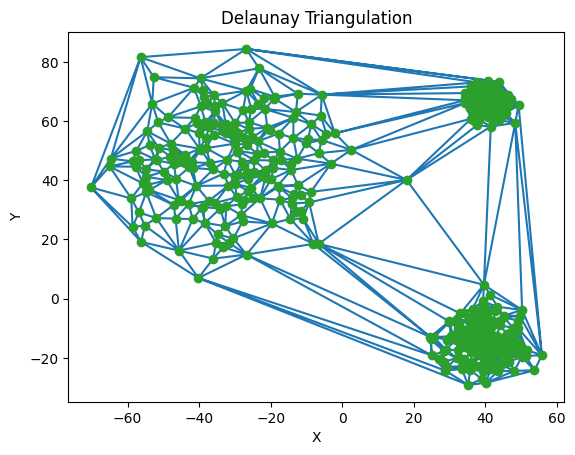

Minimum edge length: 0.019867654652673133
Maximum edge length: 84.77565918027635
Average edge length: 3.559924153402418
Eps bounds: 0.019867654652673133, 169.5513183605527
Point [39.63715442 65.69490655] has 1 neighbors within min_length and 498 neighbors within avg_length
Point [43.11767394 63.74282877] has 1 neighbors within min_length and 502 neighbors within avg_length
Point [38.66127338 68.80525795] has 1 neighbors within min_length and 457 neighbors within avg_length
Point [42.34485653 60.32475164] has 1 neighbors within min_length and 528 neighbors within avg_length
Point [42.64162695 61.74734981] has 1 neighbors within min_length and 518 neighbors within avg_length
Point [38.76496523 65.07564001] has 1 neighbors within min_length and 504 neighbors within avg_length
Point [39.26098953 64.22210305] has 1 neighbors within min_length and 514 neighbors within avg_length
Point [37.55551466 67.70741203] has 1 neighbors within min_length and 477 neighbors within avg_length
Point [35.82

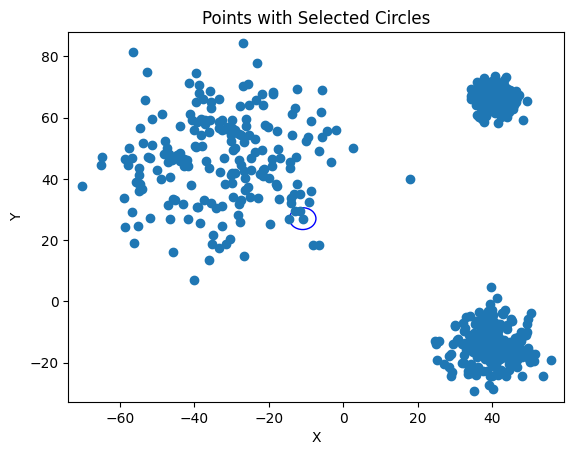

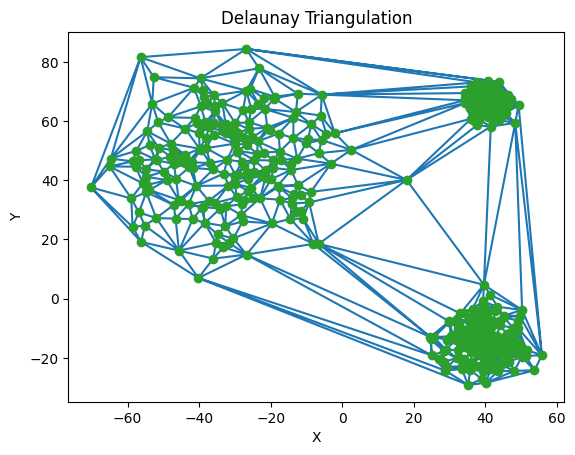

Minimum edge length: 0.019867654652673133
Maximum edge length: 84.77565918027635
Average edge length: 3.559924153402418
Eps bounds: 0.019867654652673133, 169.5513183605527
Point [39.63715442 65.69490655] has 1 neighbors within min_length and 498 neighbors within avg_length
Point [43.11767394 63.74282877] has 1 neighbors within min_length and 502 neighbors within avg_length
Point [38.66127338 68.80525795] has 1 neighbors within min_length and 457 neighbors within avg_length
Point [42.34485653 60.32475164] has 1 neighbors within min_length and 528 neighbors within avg_length
Point [42.64162695 61.74734981] has 1 neighbors within min_length and 518 neighbors within avg_length
Point [38.76496523 65.07564001] has 1 neighbors within min_length and 504 neighbors within avg_length
Point [39.26098953 64.22210305] has 1 neighbors within min_length and 514 neighbors within avg_length
Point [37.55551466 67.70741203] has 1 neighbors within min_length and 477 neighbors within avg_length
Point [35.82

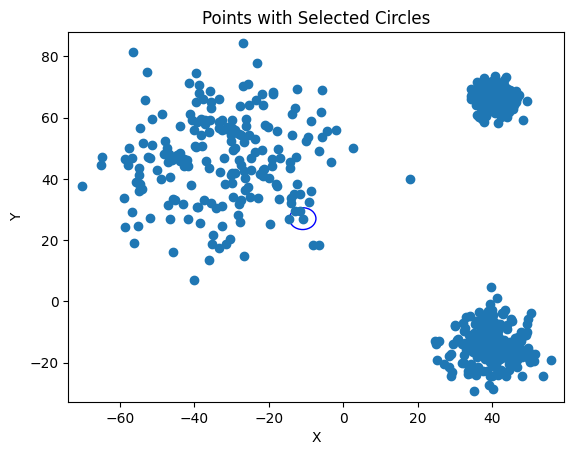


min pts bounds:
(1, 600)
##################################### Generation number :#####################################
1


<ipython-input-6-e2eb30b44e6c>:25: RuntimeWarning: invalid value encountered in scalar subtract
  norm_diff = (points[sorted_indices[i + 1, m], m] - points[sorted_indices[i - 1, m], m]) / (points[sorted_indices[-1, m], m] - points[sorted_indices[0, m], m])
<ipython-input-6-e2eb30b44e6c>:25: RuntimeWarning: invalid value encountered in scalar divide
  norm_diff = (points[sorted_indices[i + 1, m], m] - points[sorted_indices[i - 1, m], m]) / (points[sorted_indices[-1, m], m] - points[sorted_indices[0, m], m])


##################################### Generation number :#####################################
2
##################################### Generation number :#####################################
3
##################################### Generation number :#####################################
4
##################################### Generation number :#####################################
5
##################################### Generation number :#####################################
6
##################################### Generation number :#####################################
7
##################################### Generation number :#####################################
8
##################################### Generation number :#####################################
9
##################################### Generation number :#####################################
10

current_pf_f1 of generation 10 is [8.62792451 0.         0.         0.        ]
old_pf_f1 of generation 10 is [8.62792451 0. 

<ipython-input-9-41b605da5af8>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


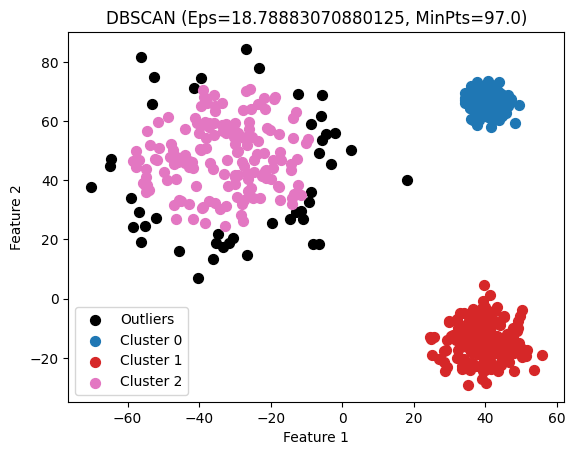

<ipython-input-9-41b605da5af8>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


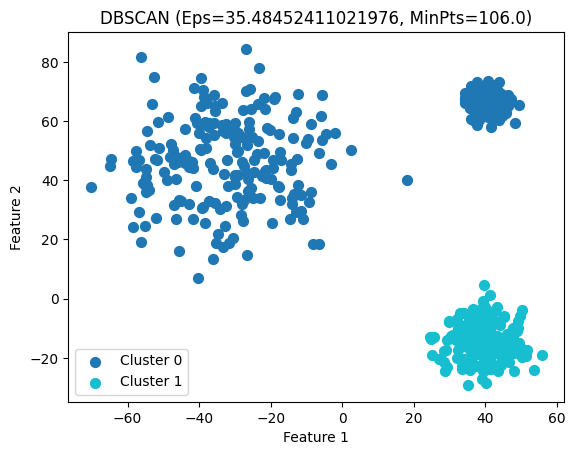

<ipython-input-9-41b605da5af8>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


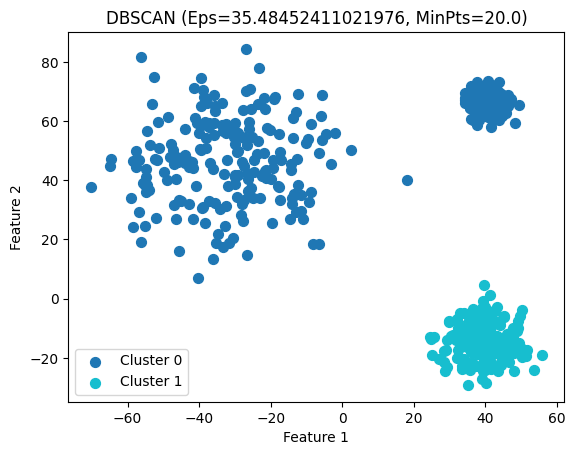

<ipython-input-9-41b605da5af8>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


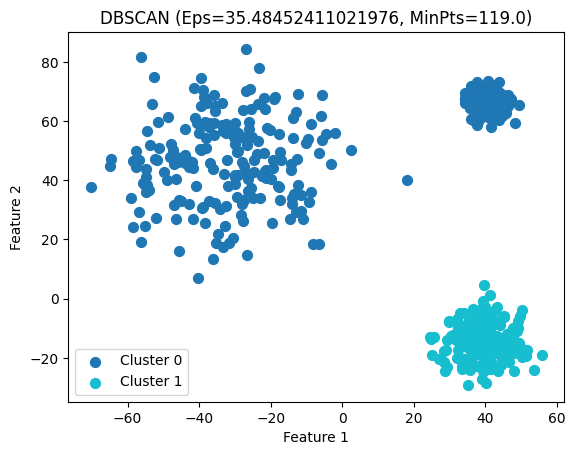

Runtime: 9.8202 seconds


In [ ]:
import time
random_state = 200
np.random.seed(random_state)
random.seed(random_state)
! gdown 1q2guKt50l17nRp6H9ZfDBUx6xv2Lvskt


# Example usage:
data = pd.read_csv('custom_cluster_dataset.csv').values
data  = data[:, :2]  # Use only the first two columns for clustering
start_time = time.perf_counter()
run_moga_on_dataset(data)
end_time = time.perf_counter()

runtime = end_time - start_time
print(f"Runtime: {runtime:.4f} seconds")


# User Selected on network dataset

<ipython-input-24-e563a96b3ac5>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


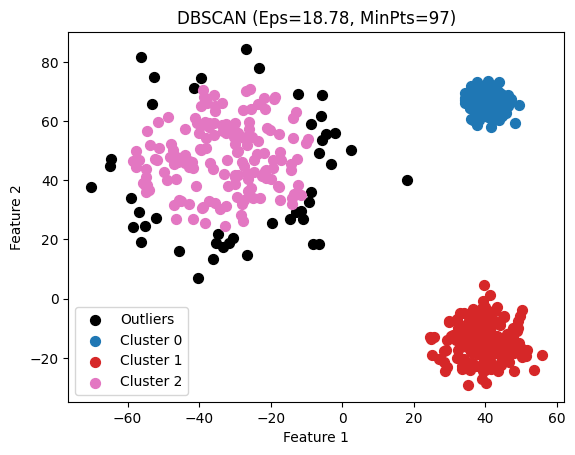

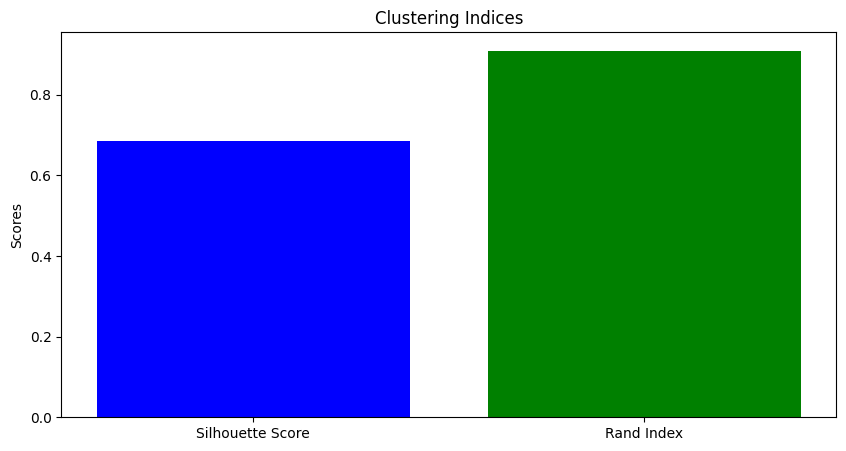

{'Silhouette Score': 0.6862905346376005, 'Rand Index': 0.9098748274975045}


In [26]:
# Load dataset

data = pd.read_csv('custom_cluster_dataset.csv').values
# Separate features and true labels
points = data[:, :2]
true_labels = data[:, -1].astype(int)

# Example usage
eps = 18.78
min_samples = 97

indices = evaluate_dbscan(points, eps, min_samples, true_labels)
print(indices)

Downloading...
From: https://drive.google.com/uc?id=1CReVmPichuLCTTjzdaqjnxMeE55svGdc
To: /content/network.csv
100% 104k/104k [00:00<00:00, 82.3MB/s]


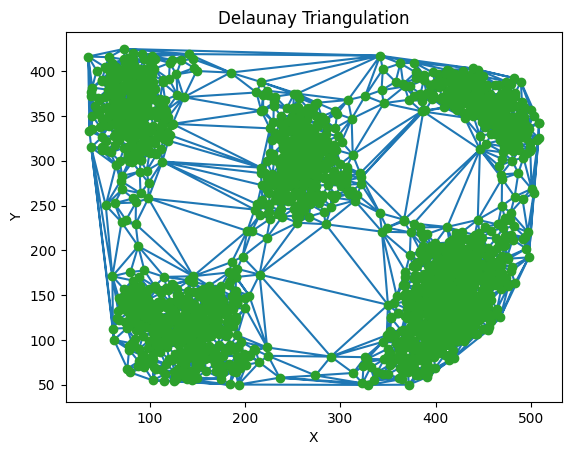

Minimum edge length: 0.025863841587996116
Maximum edge length: 268.6346070892578
Average edge length: 6.989204674258665
Eps bounds: 0.025863841587996116, 537.2692141785157
Point [ 67.03237969 131.7772576 ] has 1 neighbors within min_length and 1129 neighbors within avg_length
Point [412.51752863 156.7067159 ] has 1 neighbors within min_length and 1912 neighbors within avg_length
Point [109.73028997 364.40823725] has 1 neighbors within min_length and 1204 neighbors within avg_length
Point [448.5118291  343.29183626] has 1 neighbors within min_length and 1653 neighbors within avg_length
Point [405.99714729 128.72570834] has 1 neighbors within min_length and 1921 neighbors within avg_length
Point [445.44640139 170.85685668] has 1 neighbors within min_length and 1743 neighbors within avg_length
Point [295.02649937 261.37080599] has 1 neighbors within min_length and 2587 neighbors within avg_length
Point [191.14438448  74.40679478] has 1 neighbors within min_length and 1678 neighbors within

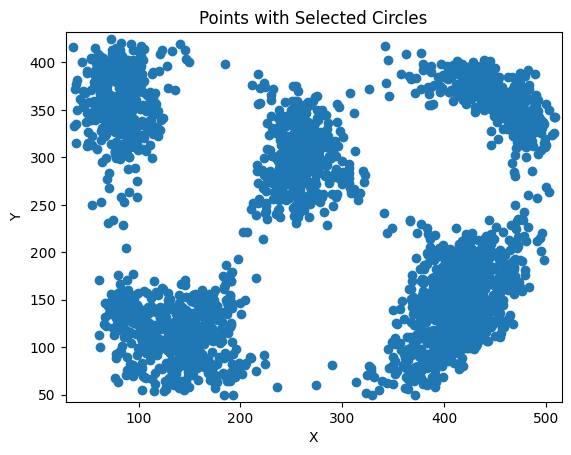

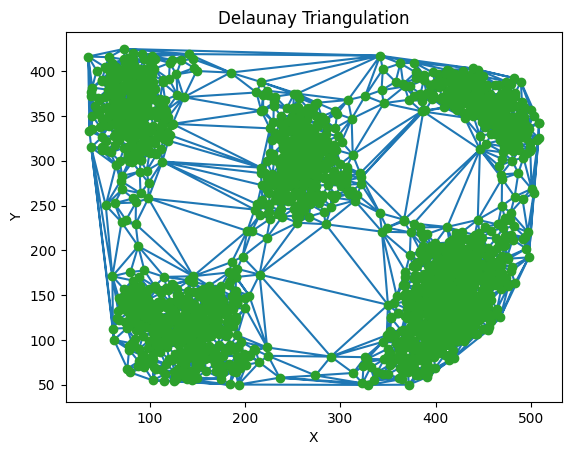

Minimum edge length: 0.025863841587996116
Maximum edge length: 268.6346070892578
Average edge length: 6.989204674258665
Eps bounds: 0.025863841587996116, 537.2692141785157
Point [ 67.03237969 131.7772576 ] has 1 neighbors within min_length and 1129 neighbors within avg_length
Point [412.51752863 156.7067159 ] has 1 neighbors within min_length and 1912 neighbors within avg_length
Point [109.73028997 364.40823725] has 1 neighbors within min_length and 1204 neighbors within avg_length
Point [448.5118291  343.29183626] has 1 neighbors within min_length and 1653 neighbors within avg_length
Point [405.99714729 128.72570834] has 1 neighbors within min_length and 1921 neighbors within avg_length
Point [445.44640139 170.85685668] has 1 neighbors within min_length and 1743 neighbors within avg_length
Point [295.02649937 261.37080599] has 1 neighbors within min_length and 2587 neighbors within avg_length
Point [191.14438448  74.40679478] has 1 neighbors within min_length and 1678 neighbors within

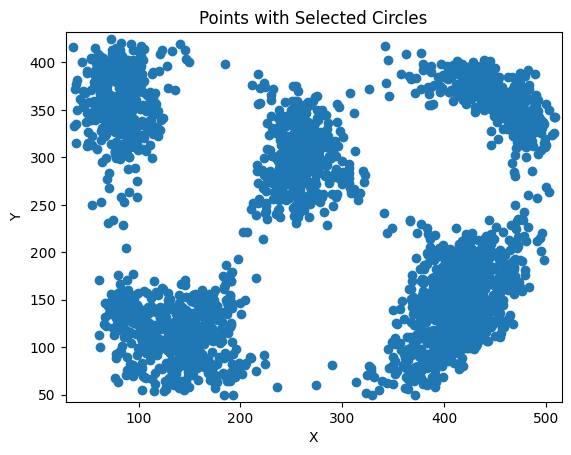


min pts bounds:
(1, 2634)
##################################### Generation number :#####################################
1
##################################### Generation number :#####################################
2
##################################### Generation number :#####################################
3
##################################### Generation number :#####################################
4
##################################### Generation number :#####################################
5
##################################### Generation number :#####################################
6
##################################### Generation number :#####################################
7
##################################### Generation number :#####################################
8
##################################### Generation number :#####################################
9
##################################### Generation number :#####################################
10

c

<ipython-input-10-41b605da5af8>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


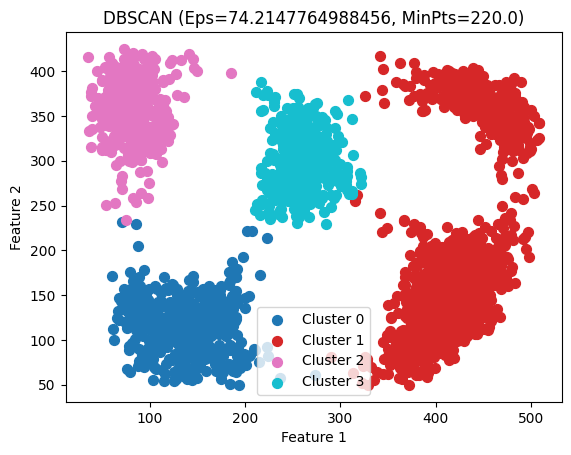

<ipython-input-10-41b605da5af8>:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


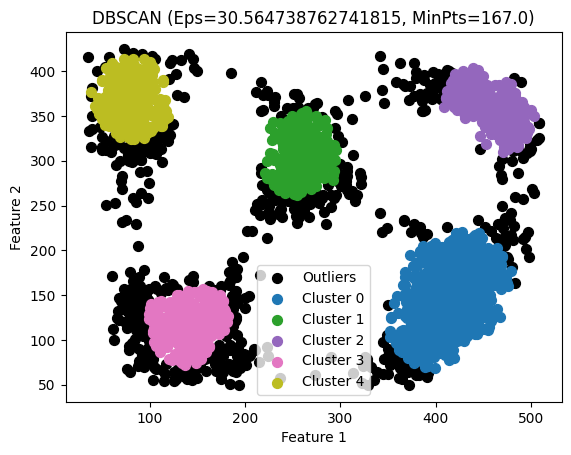

Runtime: 373.0894 seconds


In [22]:
import time
random_state = 11
np.random.seed(random_state)
random.seed(random_state)
! gdown '1CReVmPichuLCTTjzdaqjnxMeE55svGdc'

# Example usage:
data = pd.read_csv('network.csv').values
data  = data[:, :2]  # Use only the first two columns for clustering
start_time = time.perf_counter()
run_moga_on_dataset(data)
end_time = time.perf_counter()

runtime = end_time - start_time
print(f"Runtime: {runtime:.4f} seconds")


# User Selected on network dataset

<ipython-input-24-e563a96b3ac5>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


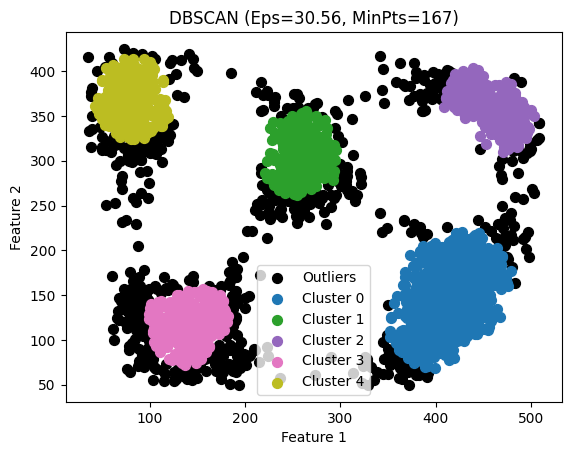

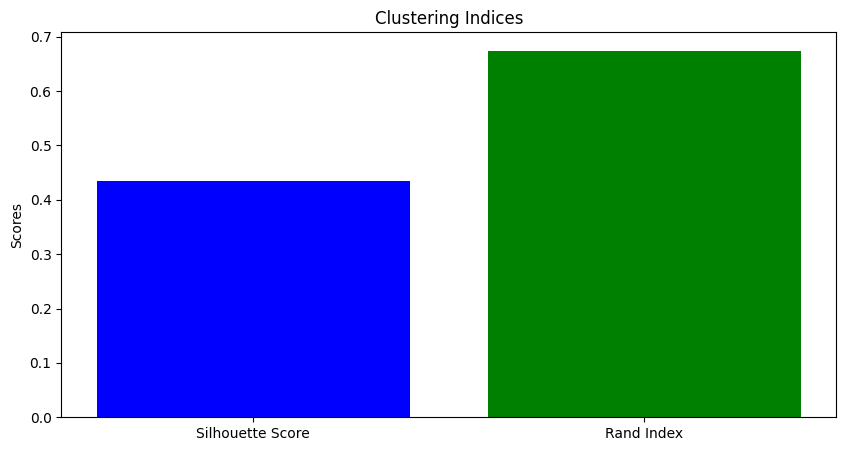

{'Silhouette Score': 0.43545348810709, 'Rand Index': 0.6743485537212377}


In [25]:
# Load dataset
data = pd.read_csv('network.csv').values
# Separate features and true labels
points = data[:, :2]
true_labels = data[:, -1].astype(int)

# Example usage
eps = 30.56
min_samples = 167

indices = evaluate_dbscan(points, eps, min_samples, true_labels)
print(indices)